In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [99]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [100]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [101]:
train.sample()

,Provider,PotentialFraud
2816,PRV54509,No


In [102]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
37137,BENE147090,CLM52033,2009-05-20,2009-06-06,PRV57527,9000,PHY329052,NaN,NaN,2009-05-20,3310,1068.0,2009-06-06,034,3310,V1254,1122,44020,V1002,53081,2724,53550,4019,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
inpatient['Provider'].nunique()

2092

In [104]:
df = inpatient.groupby('Provider').agg(
    IPTotalInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'sum'),
    IPMeanInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'mean')
)

In [105]:
df

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed
Provider,,
PRV51001,97000,19400.000000
PRV51003,573000,9241.935484
PRV51007,19000,6333.333333
PRV51008,25000,12500.000000
PRV51011,5000,5000.000000
...,...,...
PRV57719,76000,19000.000000
PRV57728,6000,6000.000000
PRV57729,107000,9727.272727


In [106]:
outpatient['Provider'].nunique()

5012

In [107]:
out_df = outpatient.groupby('Provider').agg(
    OPTotalInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'sum'),
    OPMeanInscClaimAmtReimbursed = ('InscClaimAmtReimbursed', 'mean')
)
out_df

,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
Provider,,
PRV51001,7640,382.000000
PRV51003,32670,466.714286
PRV51004,52170,350.134228
PRV51005,280910,241.124464
PRV51007,14710,213.188406
...,...,...
PRV57759,10640,380.000000
PRV57760,4770,216.818182
PRV57761,18470,225.243902


In [108]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left: Provider, IP_Claims_Total
    out_df,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='outer'
).reset_index().fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [109]:
provider_claims

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
0,PRV51001,97000.0,19400.000000,7640.0,382.000000
1,PRV51003,573000.0,9241.935484,32670.0,466.714286
2,PRV51004,0.0,0.000000,52170.0,350.134228
3,PRV51005,0.0,0.000000,280910.0,241.124464
4,PRV51007,19000.0,6333.333333,14710.0,213.188406
...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000
5406,PRV57760,0.0,0.000000,4770.0,216.818182
5407,PRV57761,0.0,0.000000,18470.0,225.243902
5408,PRV57762,0.0,0.000000,1900.0,1900.000000


In [110]:
# # Save selected columns to CSV
# provider_claims.to_csv('2 draft.csv', index=False)

In [111]:
provider_claims['IPTotalInscClaimAmtReimbursed'].sum()

np.float64(408297020.0)

In [112]:
provider_claims['OPTotalInscClaimAmtReimbursed'].sum()

np.float64(148246120.0)

In [113]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [114]:
final_df

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,No
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,Yes
2,PRV51004,0.0,0.000000,52170.0,350.134228,No
3,PRV51005,0.0,0.000000,280910.0,241.124464,Yes
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,No
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000,No
5406,PRV57760,0.0,0.000000,4770.0,216.818182,No
5407,PRV57761,0.0,0.000000,18470.0,225.243902,No
5408,PRV57762,0.0,0.000000,1900.0,1900.000000,No


In [115]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,0
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,1
2,PRV51004,0.0,0.000000,52170.0,350.134228,0
3,PRV51005,0.0,0.000000,280910.0,241.124464,1
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,0
...,...,...,...,...,...,...
5405,PRV57759,0.0,0.000000,10640.0,380.000000,0
5406,PRV57760,0.0,0.000000,4770.0,216.818182,0
5407,PRV57761,0.0,0.000000,18470.0,225.243902,0
5408,PRV57762,0.0,0.000000,1900.0,1900.000000,0


# Modeling part

In [116]:
X = final_df[[
      'IPTotalInscClaimAmtReimbursed',
      'IPMeanInscClaimAmtReimbursed',
      'OPTotalInscClaimAmtReimbursed',
      'OPMeanInscClaimAmtReimbursed']]

In [117]:
y = final_df['PotentialFraud']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [119]:
# I have 80% of the data here, without the potential fraud column
X_train

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
3682,0.0,0.000000,800.0,800.000000
1323,50000.0,7142.857143,21070.0,309.852941
1583,0.0,0.000000,3520.0,251.428571
4318,0.0,0.000000,9600.0,204.255319
2876,0.0,0.000000,7280.0,242.666667
...,...,...,...,...
3772,0.0,0.000000,12550.0,404.838710
5191,387000.0,10459.459459,13530.0,178.026316
5226,0.0,0.000000,5330.0,144.054054
5390,0.0,0.000000,2290.0,152.666667


In [120]:
# I have 20% of the data here, without the potential fraud column
X_test

,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed
290,0.0,0.000000,18340.0,321.754386
1730,0.0,0.000000,710.0,101.428571
4235,0.0,0.000000,1200.0,300.000000
4870,10000.0,10000.000000,4050.0,368.181818
1073,597000.0,11705.882353,55190.0,330.479042
...,...,...,...,...
75,16600.0,5533.333333,0.0,0.000000
1831,40000.0,6666.666667,34780.0,244.929577
2973,0.0,0.000000,660.0,60.000000
3984,0.0,0.000000,126120.0,321.734694


In [121]:
# I have 80% of the potential fraud column, to train the model
y_train

3682    0
1323    0
1583    0
4318    0
2876    0
       ..
3772    0
5191    1
5226    0
5390    0
860     0
Name: PotentialFraud, Length: 4328, dtype: int64

In [122]:
# I have 20% of the potential fraud column, to test the model
y_test

290     0
1730    0
4235    0
4870    0
1073    0
       ..
75      0
1831    0
2973    0
3984    0
3214    0
Name: PotentialFraud, Length: 1082, dtype: int64

In [123]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [124]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [125]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [126]:
model.predict_proba(X_test)

array([[0.98158073, 0.01841927],
       [0.98494549, 0.01505451],
       [0.98473092, 0.01526908],
       ...,
       [0.98498132, 0.01501868],
       [0.94171268, 0.05828732],
       [0.95421249, 0.04578751]])

In [127]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix before manipulating by adding the threshold\nConfusion Matrix:")
print(cm)

Confusion Matrix before manipulating by adding the threshold
Confusion Matrix:
[[965  12]
 [ 66  39]]


In [128]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.76
Recall: 0.37
F1 Score: 0.50


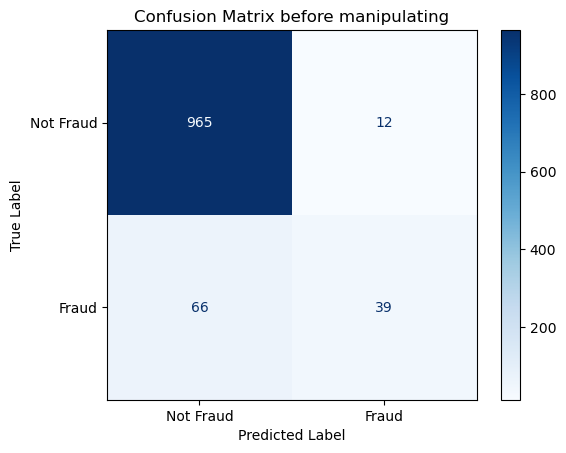

In [129]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix before manipulating')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

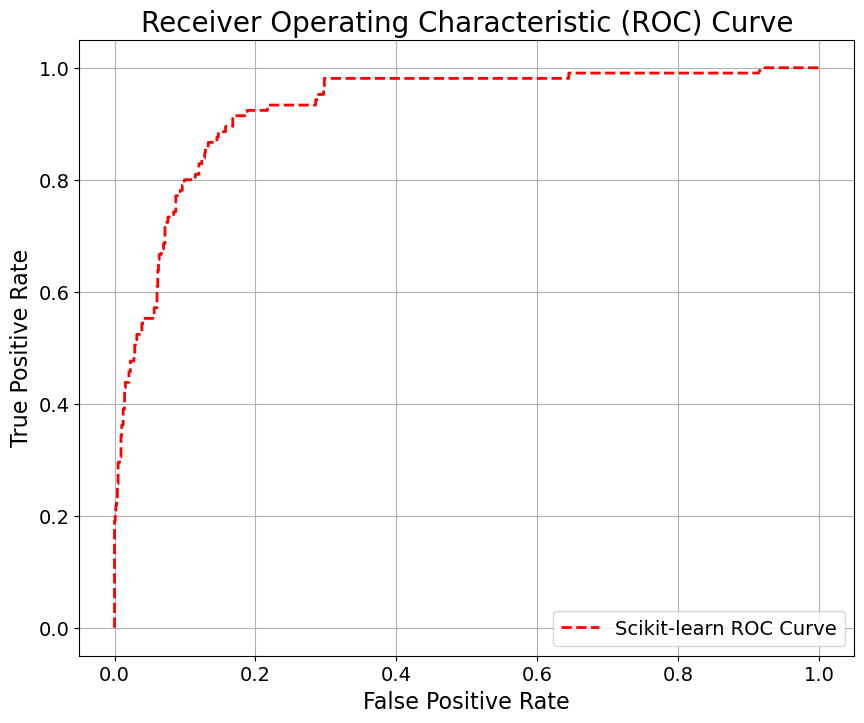

In [130]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [131]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9284690744260857)

# Applying Cross Validation

In [132]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94764889 0.94350077 0.9245264  0.93081923 0.9282413 ]
Mean auc_roc: 0.9349


## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [133]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9383


In [134]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.82      0.30      0.43       105

    accuracy                           0.93      1082
   macro avg       0.87      0.64      0.70      1082
weighted avg       0.92      0.93      0.91      1082



In [135]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[970   7]
 [ 74  31]]


# <center>SMOTE

In [136]:
# Checks how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPTotalInscClaimAmtReimbursed,IPMeanInscClaimAmtReimbursed,OPTotalInscClaimAmtReimbursed,OPMeanInscClaimAmtReimbursed,PotentialFraud
0,PRV51001,97000.0,19400.000000,7640.0,382.000000,0
1,PRV51003,573000.0,9241.935484,32670.0,466.714286,1
2,PRV51004,0.0,0.000000,52170.0,350.134228,0
3,PRV51005,0.0,0.000000,280910.0,241.124464,1
4,PRV51007,19000.0,6333.333333,14710.0,213.188406,0


In [137]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [138]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [139]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [140]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[846 135]
 [ 14  87]]


In [141]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.86
Precision: 0.39
Recall: 0.86
F1 Score: 0.54


### <center>SMOTE AUC_ROC score:

In [142]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9488


# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [143]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [144]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9500


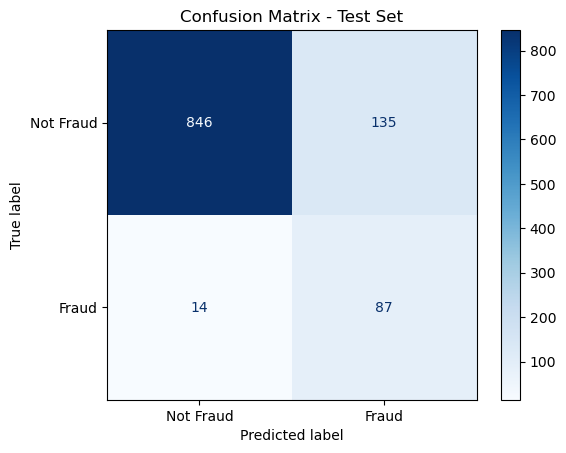

In [145]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [146]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[846 135]
 [ 14  87]]


In [147]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.86
Precision: 0.39
Recall: 0.86
F1 Score: 0.54
